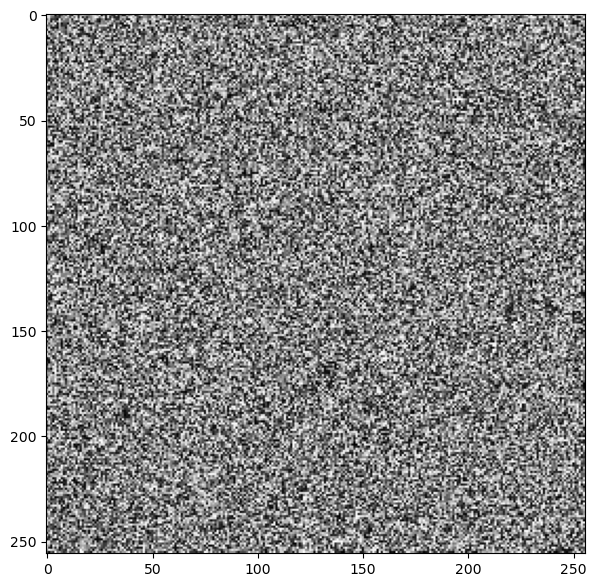

In [2]:
import numpy as np
import matplotlib.pyplot as plt

randomimage = np.random.randint(0 ,256, (256,256))

plt.figure(figsize = (7,7))
plt.imshow(randomimage, cmap = 'gray')
plt.show()

In [ ]:
import os
import numpy as np
import pandas as pd

from PIL import Image
from sklearn import ensemble
from sklearn import metrics
from sklearn import model_selection
from tqdm import tqdm

def create_dataset(training_df, image_dir):
    '''
    This function takes the training dataframe
    and outputs training array and labels
    :param training_df: This is the training dataframe
    :param image_dir: This is the directory where the image files are located   
    :return X.y training array with features and labels
    '''
    # Create an empty list to store the image vectors
    images = []

    # create a list to store the targets
    targets = []

    # loop over the dataframe
    for index, row in tqdm(training_df.iterrows(), total = len(training_df), desc = 'Processing Images'):
        # get the image id
        image_id = row['image_id']
        # create the image path
        image_path = os.path.join(image_dir, image_id + '.png')
        # open the image using PIL
        image = Image.open(image_path + '.png')
        # convert the image to array
        image = image.resize((256,256), resample=Image.BILINEAR)
        image = np.array(image)
        # ravel the image
        image = image.ravel()
        # append the image to the list
        images.append(image)
        # append the target to the list
        targets.append(int(row['target']))
        # convert the list to numpy array
        images = np.array(images)
        print(images.shape)
        return images, targets

if __name__ == '__main__':
    csv_path = '../input/train.csv'
    image_path = '../input/train_png/'

    # read csv with imageid and target columns
    df = pd.read_csv(csv_path)

    # create a new kfold column
    df['kfold'] = -1

    # randomize the rows of the data
    df = df.sample(frac = 1).reset_index(drop = True)

    # fetch targets
    y = df.target.values

    # initiate the kfold class from model_selection module
    kf = model_selection.StratifiedKFold(n_splits = 5)

    # fill the new kfold column
    for f, (t_, v_) in enumerate(kf.split(X = df, y = y)):
        df.loc[v_, 'kfold'] = f
    
    # iterate over the folds
    for fold_ in range(5):
        # temporary dataframes for train and validation
        train_df = df[df.fold != fold_].reset_index(drop = True)
        valid_df = df[df.fold == fold_].reset_index(drop = True)

        # create train and validation datasets
        xtrain, ytrain = create_dataset(train_df, image_path)
        xvalid, yvalid = create_dataset(valid_df, image_path)

        # fit a simple random forest on the training
        clf = ensemble.RandomForestClassifier(n_jobs = -1)
        clf.fit(xtrain, ytrain)

        # predict on the validation of class 1
        preds = clf.predict_proba(xvalid)[:, 1]

        print(f'fold: {fold_}')
        print(f'AUC = {metrics.roc_auc_score(yvalid, preds)}')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        # convolutional part
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=96,
            kernel_size = 11,
            stride = 4,
            padding = 0
        )
        self.pool1 = nn.MaxPool2d(kernel_size = 3, stride = 2)
        self.conv2 = nn.Conv2d(
            in_channels=96,
            out_channels=256,
            kernel_size = 5,
            stride = 1,
            padding = 2
        )
        self.pool2 = nn.MaxPool2d(kernel_size = 3, stride = 2)
        self.conv3 = nn.Conv2d(
            in_channels=256,
            out_channels=384,
            kernel_size = 3,
            stride = 1,
            padding = 1
        )
        self.cov4 = nn.Conv2d(
            in_channels=384,
            out_channels=384,
            kernel_size = 3,
            stride = 1,
            padding = 1
        )
        self.conv5 = nn.Conv2d(
            in_channels=384,
            out_channels=256,
            kernel_size = 3,
            stride = 1,
            padding = 1
        )
        self.pool3 = nn.MaxPool2d(kernel_size = 3, stride = 2)
        # dense part
        self.fc1 = nn.Linear(9216, 4096)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(4096, 4096)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(4096, 1000)
    
    def forward(self,image):

        # get the batch size, channels, height, and width
        bc, c, h, w = image.size()
        x = F.relu(self.conv1(image)) # size = (bc, 96, 55, 55)
        x = self.pool1(x) # size = (bc, 96, 27, 27)
        x = F.relu(self.conv2(x)) # size = (bc, 256, 27, 27)
        self.pool2(x) # size = (bc, 256, 13, 13)
        x = F.relu(self.conv3(x)) # size = (bc, 384, 13, 13)
        x = F.relu(self.conv4(x)) # size = (bc, 384, 13, 13)
        x = F.relu(self.conv5(x)) # size = (bc, 256, 13, 13)
        x = self.pool3(x) # size = (bc, 256, 6, 6)
        x = x.view(bc, -1) # size = (bc, 9216)
        x = F.relu(self.fc1(x)) # size = (bc, 4096)
        x = self.dropout1(x) # size = (bc, 4096)
        # dropout does not change the size and it is used for regularization 0.3 means 30% of the neurons will be turned off
        x = F.relu(self.fc2(x)) # size = (bc, 4096)
        x = self.dropout2(x) # size = (bc, 4096)
        x = self.fc3(x) # size = (bc, 1000) # 1000 is the number of classes in the imagenet dataset
        x = torch.softmax(x, dim = 1) # size = (bc, 1000) 
        # softmax is used to convert the output to probabilities
        return x